# <font size="7"> **Assignment-7**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [37]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 7

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [38]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size = 0.3, random_state = GROUP_NUMBER)

In [39]:
def init_params(in_dim, hidden_dim, out_dim, num_hidden):
    weights = []
    biases = []

    # Input -> first hidden
    w = torch.randn(in_dim, hidden_dim) * torch.sqrt(torch.tensor(2.0 / in_dim))
    b = torch.zeros(hidden_dim)
    weights.append(w)
    biases.append(b)

    # Hidden -> hidden
    for hidden in range(num_hidden - 1):
        w = torch.randn(hidden_dim, hidden_dim) * torch.sqrt(torch.tensor(2.0 / hidden_dim))
        b = torch.zeros(hidden_dim)
        weights.append(w)
        biases.append(b)

    # Last hidden -> output
    w = torch.randn(hidden_dim, out_dim) * torch.sqrt(torch.tensor(1.0 / hidden_dim))
    b = torch.zeros(out_dim)
    weights.append(w)
    biases.append(b)

    # Enable gradients
    for p in weights + biases:
        p.requires_grad_()

    return weights, biases

In [40]:
weights, biases = init_params(2, 16, 1, 3)

In [41]:
w1, w2, w3, w4 = weights
b1, b2, b3, b4 = biases

In [42]:
def Binary_Cross_Entropy_Loss(y_pred, y_true):
    eps = 1e-15
    y_pred = torch.clamp(y_pred, eps, 1 - eps)

    loss = - torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    return loss

In [43]:
def forward(X):
    z1 = torch.matmul(X, w1) + b1
    a1 = torch.relu(z1)
    z2 = torch.matmul(a1, w2) + b2
    a2 = torch.relu(z2)
    z3 = torch.matmul(a2, w3) + b3
    a3 = torch.relu(z3)
    z4 = torch.matmul(a3, w4) + b4
    y_pred = torch.sigmoid(z4)

    return y_pred

In [44]:
def accuracy(y_pred, y_true):
    return ((y_pred > 0.5) == y_true).float().mean()

In [45]:
# Hyperparameters
epochs = 10000
lr = 0.01

loss_tr = torch.zeros(epochs)
acc_tr = torch.zeros(epochs)

loss_va = torch.zeros(epochs)
acc_va = torch.zeros(epochs)

In [46]:
for ep in range(epochs):
    pred_tr = forward(X_train)
    loss = Binary_Cross_Entropy_Loss(pred_tr, y_train)
    loss_tr[ep] = loss.detach()
    acc_tr[ep] = accuracy(pred_tr, y_train)

    loss.backward()
    with torch.no_grad():
        for param in [w1, b1, w2, b2, w3, b3, w4, b4]:
            param -= lr * param.grad
            param.grad.zero_()

    with torch.no_grad():
        pred_va = forward(X_val)
        loss_va[ep] = Binary_Cross_Entropy_Loss(pred_va, y_val).detach()
        acc_va[ep] = accuracy(pred_va, y_val)

    if ep % 1000 == 0:
        print(
            f"Epoch {ep} : "
            f"Train Loss = {loss_tr[ep]:.4f} | Train Acc = {acc_tr[ep]:.4f} | "
            f"Val Loss = {loss_va[ep]:.4f} | Val Acc = {acc_va[ep]:.4f}")

Epoch 0 : Train Loss = 1.5030 | Train Acc = 0.3743 | Val Loss = 1.1448 | Val Acc = 0.4456
Epoch 1000 : Train Loss = 0.6026 | Train Acc = 0.5829 | Val Loss = 0.6244 | Val Acc = 0.5433
Epoch 2000 : Train Loss = 0.5900 | Train Acc = 0.5848 | Val Loss = 0.6105 | Val Acc = 0.5656
Epoch 3000 : Train Loss = 0.5776 | Train Acc = 0.6129 | Val Loss = 0.5967 | Val Acc = 0.6200
Epoch 4000 : Train Loss = 0.5614 | Train Acc = 0.6562 | Val Loss = 0.5775 | Val Acc = 0.6611
Epoch 5000 : Train Loss = 0.5167 | Train Acc = 0.7424 | Val Loss = 0.5322 | Val Acc = 0.7456
Epoch 6000 : Train Loss = 0.4578 | Train Acc = 0.7914 | Val Loss = 0.4660 | Val Acc = 0.7911
Epoch 7000 : Train Loss = 0.4162 | Train Acc = 0.8162 | Val Loss = 0.4237 | Val Acc = 0.8144
Epoch 8000 : Train Loss = 0.3778 | Train Acc = 0.8657 | Val Loss = 0.3879 | Val Acc = 0.8611
Epoch 9000 : Train Loss = 0.3321 | Train Acc = 0.9157 | Val Loss = 0.3483 | Val Acc = 0.9056


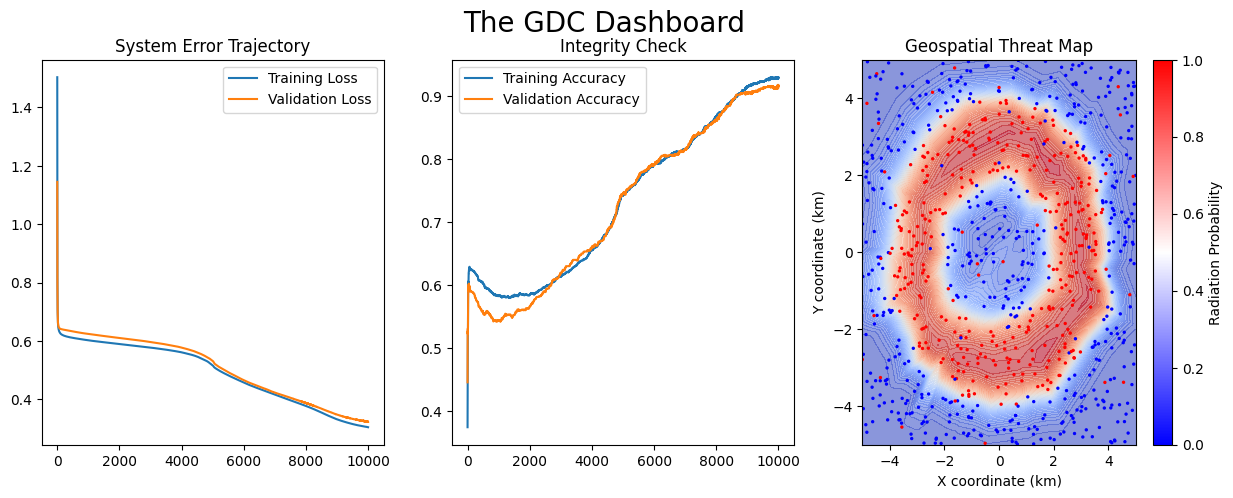

In [47]:
# Plot
import matplotlib.pyplot as plt

plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.plot(loss_tr, label = "Training Loss")
plt.plot(loss_va, label = "Validation Loss")
plt.title("System Error Trajectory")
plt.legend()

plt.subplot(1,3,2)
plt.plot(acc_tr, label = "Training Accuracy")
plt.plot(acc_va, label = "Validation Accuracy")
plt.title("Integrity Check")
plt.legend()

plt.subplot(1,3,3)
x_min, x_max = -5, 5
y_min, y_max = -5, 5
x, y = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
grid = torch.tensor(np.c_[x.ravel(), y.ravel()], dtype = torch.float32)
with torch.no_grad():
    probs = forward(grid).reshape(x.shape)
plt.contourf(x, y, probs, levels = 50, cmap = "coolwarm", alpha = 0.6)
plt.scatter(X_val[:, 0], X_val[:, 1], c = y_val[:,0], cmap = "bwr", s = 2)
plt.xlabel("X coordinate (km)")
plt.ylabel("Y coordinate (km)")
plt.title("Geospatial Threat Map")
plt.colorbar(label="Radiation Probability")

plt.suptitle("The GDC Dashboard", fontsize = 20)
plt.show()

In [48]:
print(f"Final Training Accuracy: {acc_tr[-1] * 100 :.2f} %")
print(f"Final Validation Accuracy: {acc_va[-1] * 100 :.2f} %")

Final Training Accuracy: 92.95 %
Final Validation Accuracy: 91.67 %


This shows that we did **overcome** the **overfitting** problem because the training accuracy and validation accuration are nearly the same